In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# INF554 Assessment: Trees, Bagging and Boosting

In this assessment it is your task to delve deeper into the construction of classification tree-based models.

**Please submit a zip file containing the following to moodle by the 30th October 2023 14.00 (Paris time):**

- your filled out assessment jupyter notebook on the proposed coding tasks;
- a pdf containing your short written answers to the questions in this notebook.

Make sure to submit a couple of hours ahead of the deadline to ensure that technical difficulties do not cause you to miss the deadline. Late submissions will not be accepted.

Please note that this assessment is *to be completed individually. We will forward detected cases of plagarism to the university,* which in serious cases can have farreaching consequences for you. So, please make sure to submit your own, original solutions to this assessment. 

*Disclaimer:* You will not receive marks for importing the functions that you are asked to code from any library, unless specifically stated in the corresponding task. In this assessment, we ask you to code these methods from scratch in the hope that this will give you a better understanding of them.

## Data set

In this assessment, you will be working with the <a href="https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database">Pima-indians-diabetes</a> dataset which originates from a study that aimed to predict the presence (Outcome=1) or not (Outcome=0) of diabetes in 768 female patients who were at least 21 years old and had Pima Indian origin. For this purpose, the following diagnostic measures were considered: number of pregnancies (Pregnancies, $X_1$), plasma glucose concentration (Glucose, $X_2$), diastolic blood pressure (BloodPressure, $X_3$), triceps skinfold thickness (SkinThickness, $X_4$), serum insulin (Insulin, $X_5$), ́body mass index (BMI, $X_6$), diabetes pedigree function (DiabetesPedigreeFunction, $X_7$) and age (Age, $X_8$). Thus, we have 8 predictor variables and the binary response variable Outcome, which we denote by $Y$.

In [64]:
df = pd.read_csv("diabetes.csv")
print(df.head())
features = df.columns[0:(len(df.columns)-1)]
X = np.array(df[features])
y = np.array(df.Outcome)

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


## A. Trees

In this section, we will learn how to construct a classification tree. Suppose we are given a training sample of $N$ individuals, $\left\lbrace \left(x_i,y_i \right) \right\rbrace_{1\leq i\leq N}$, on which $d$ predictor variables are measured, $x_i\in\mathbb{R}^d$, and one class label is associated with each one, $y_i\in\left\lbrace 1,\ldots, K\right\rbrace$. Classic classification tree methods consist of sequentially, and greedily, partitioning the predictor space $\mathbb{R}^d$ into disjoint sets or *nodes* by imposing certain conditions on the predictor variables. The usual splitting criterion is to take the split that makes descendant nodes purer, i.e., nodes with observations more and more homogenous in terms of class membership. The process of partitioning finishes when a stopping criterion is satisfied. Then, leaf nodes are labeled with a class label, $1,\ldots,K$. Commonly, a leaf node is labeled with the most frequent class in the individuals that have fallen into the node. Once the tree is built, the prediction of future unlabeled data is done in a deterministic way. Given a new observation, starting from the root node, it will end up in a leaf node, depending on the values the predictor variables take, and its predicted class will be the class label of that leaf node. Because of their construction, normalization of the data is not required.

Specifically, we will focus on binary classification trees with univariate splits. Given a node $t$, the proposed splitting for continuous features is to generate the following left and right child nodes: $t_L = \left\lbrace u\in t: x_{ju} \leq b_t\right\rbrace$ and $t_R = \left\lbrace u\in t: x_{ju} > b_t\right\rbrace$, where cutpoint $b_t$ is the halfway between two consecutive data values of feature $x_j$. Assuming that these values are ordered from lowest to highest, at most $N-1$ different divisions can be done. As said, the best split will be the one that best separate the objects in the training sample up to their classes, that is, that produces the maximum reduction in the diversity or impurity of objects associated to resultant nodes. In the following, we study different quantitative ways to measure the impurity of a node.

### Node impurity measures

Given node $t$, an impurity measure $i(t)$ can be defined by:

**Misclassification:** $1 - \max_{1\leq k\leq K} \left\lbrace p_k(t)\right\rbrace$

**Entropy:** $-\sum_{k=1}^K p_k(t) \log_2 p_k(t)$, with the agreement that $0\log_2 0 = 0$.

**Gini-index:** $\sum_{k=1}^K p_k(t) \left( 1-p_k(t)\right) = 1 - \sum_{k=1}^K p_k^2(t)$

where $p_k(t) = \dfrac{n_k(t)}{n(t)}$ is the proportion of samples in node $t$ that belong to class $k$.

>**Task 1: (3 Points)** Complete the below functions to define the three impurity measures above. In addition, plot them together as a function of $p_1(t)$ for a given binary classification problem ($K=2$).

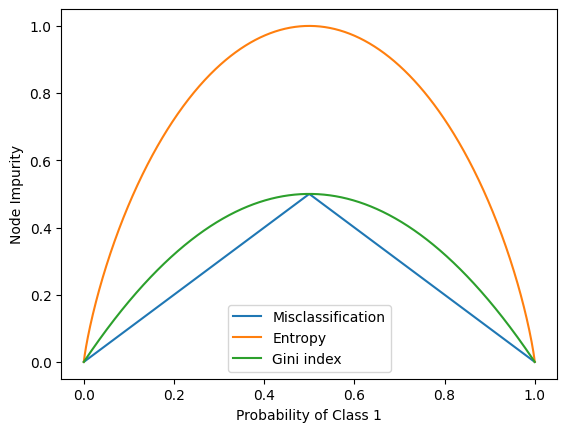

In [65]:
def misclassification(p):
    """
    Inputs:
        p (K-dimensional vector): class probability distribution at a given node t
    Outputs:
        i (float): misclassification impurity measure at node t
    """
    return 1 - np.max(p)

def entropy(p):
    """
    Inputs:
        p (K-dimensional vector): class probability distribution at a given node t
    Outputs:
        i (float): entropy impurity measure at node t
    """
    entropy = 0
    for i in range(len(p)):
        if p[i] != 0:
            entropy -= p[i]*np.log2(p[i])
    return entropy

def gini_index(p):
    """
    Inputs:
        p (K-dimensional vector): class probability distribution at a given node t
    Outputs:
        i (float): Gini index impurity measure at node t
    """
    index = 0
    for i in range(len(p)):
        index += p[i]*(1-p[i])
    return index
    
plt.figure()
x = np.linspace(0,1,1000)
y1 = [misclassification([p1,1-p1]) for p1 in x]
plt.plot(x,y1)
y2 = [entropy([p1,1-p1]) for p1 in x] 
plt.plot(x,y2)
y3 = [gini_index([p1,1-p1]) for p1 in x]
plt.plot(x,y3)
plt.legend(["Misclassification","Entropy","Gini index"])
plt.xlabel("Probability of Class 1")
plt.ylabel("Node Impurity")
plt.show()

>**Question 1: (6 Points)** Impurity measures are functions $\Phi: P \rightarrow \mathbb{R}$, where $P=\left\lbrace \left(p_1,\ldots,p_m\right): \sum\limits_{k=1}^K p_k = 1, p_k\geq 0, k=1,\ldots,K\right\rbrace$, that verify the following three properties:
> * $\Phi$ achieves its unique maximum at point $\left(\dfrac{1}{K},\ldots,\dfrac{1}{K}\right)$
> * $\Phi$ achieves its minima exclusively at the points $\left(1,0,\ldots,0\right)$, $\left(0,1,0,\ldots,0\right)$, ..., $\left(0,\ldots,0,1\right)$
> * $\Phi$ is a symmetric function of $p_1,\ldots,p_K$, i.e., if there is a permutation of the variables $p_k$, the function's output will remain unchanged.
> 1. Interpret what these three functional properties of impurity measures individually mean in the context of measuring node impurity. (At most 2 sentences per property are required.)
> 2. Show analytically for binary classification ($K=2$) that the Gini index satisfies these properties. 

Since the fundamental idea is to produce purer and purer nodes, the selection of the split of a parent node will be done in terms of the information gain, which measures somehow the purity gained when a node is split into child nodes. In what follows, this concept is formally defined.

### Information gain

Let $s\in S$ be a candidate split of data points assigned to a given node $t$, and let $i$ be an impurity function. The information gain of $s$ relative to node $t$ is defined as the average reduction of impurity obtained by splitting the observations within node $t$ up to $s$

$$ G(t,s) = i(t) - \left(q_L i\left(t_L\right) + q_R i\left(t_R\right)\right)$$

where $t_L, t_R$ are the left and right child nodes originating from the splitting of node $t$ and $q_L, q_R$ the proportion of observations (within node $t$) that become elements from new nodes $t_L, t_R$. This definition could be generalized for non-binary splitting.

Let $\Omega_c$ be the set of current leaf nodes that can be potentially split. Then, the selected split over $\Omega_c$ will be the one that maximizes the corresponding information gain:

$$ G(t^\ast, s^\ast) = \max\limits_{t\in\Omega_c,\,s\in S}\left\lbrace G(t,s) \right\rbrace$$

>**Task 2: (9 Points)** Complete the below function following the steps within it in order to produce the first split in a binary classification tree for the first 100 observations of the Pima-indians-diabetes data set and for all three impurity functions. Consider just Glucose as predictor. 

In [66]:
i = 100
feature = np.array(X[0:i,1])
labels = y[0:i]

def first_split(feature, labels, impurity_function):
    """
    Inputs:
        feature (N-dimensional vector): feature values
        labels (N-dimensional vector): target values
        impurity_function (function): misclassification, entropy or gini_index functions
    Outputs:
        impurity_parent_node (float): impurity measure of parent node t
        impurity_left_child_node (float): impurity measure of left child node t_L
        impurity_right_child_node (float): impurity measure of right child node t_R
        best_cutpoint (float): feature value from which to split b_t
    """
    # Step 1: Compute the list of candidate cutpoints ( mean of two consecutive feature values)
    
    candidate_cutpoints = []
    for i in range(len(feature)-1):
        candidate_cutpoints.append((feature[i]+feature[i+1])/2)

    # Step 2: Compute the information gain for each candidate cutpoint

    information_gain = []
    for cutpoint in candidate_cutpoints:
        left_child_node = []
        right_child_node = []
        for i in range(len(feature)):
            if feature[i] <= cutpoint:
                left_child_node.append(labels[i])
            else:
                right_child_node.append(labels[i])
        left_child_node = np.array(left_child_node)
        right_child_node = np.array(right_child_node)
        impurity_parent_node = impurity_function(np.bincount(labels)/len(labels))
        impurity_left_child_node = impurity_function(np.bincount(left_child_node)/len(left_child_node))
        impurity_right_child_node = impurity_function(np.bincount(right_child_node)/len(right_child_node))
        information_gain.append(impurity_parent_node - (len(left_child_node)/len(labels)*impurity_left_child_node + len(right_child_node)/len(labels)*impurity_right_child_node))
    
    # Step 3: Obtain the first split according to the maximum information gain

    best_cutpoint = candidate_cutpoints[information_gain.index(max(information_gain))]
    
    print('Impurity function used is:', impurity_function.__name__)
    print('Impurity at root node =', np.around(impurity_parent_node,3))
    print('The left branch is','X <=', best_cutpoint, 'with impurity =', np.around(impurity_left_child_node,3))
    print('The right branch is','X >', best_cutpoint, 'with impurity =', np.around(impurity_right_child_node,3))
    print('\n')
    
    return impurity_parent_node, impurity_left_child_node, impurity_right_child_node, best_cutpoint

first_split(feature, labels, misclassification);
first_split(feature, labels, entropy);
first_split(feature, labels, gini_index);

Impurity function used is: misclassification
Impurity at root node = 0.37
The left branch is X <= 147.5 with impurity = 0.163
The right branch is X > 147.5 with impurity = 0.474


Impurity function used is: entropy
Impurity at root node = 0.951
The left branch is X <= 113.0 with impurity = 0.641
The right branch is X > 113.0 with impurity = 0.998


Impurity function used is: gini_index
Impurity at root node = 0.466
The left branch is X <= 113.0 with impurity = 0.273
The right branch is X > 113.0 with impurity = 0.499




>**Task 3: (2 Points)** Use DecisionTreeClassifier from scikit-learn package to learn the first split for both entropy and Gini index. Are the results consistent with the output obtained in Task 2?

[Text(0.5, 0.75, 'x[0] <= 113.5\ngini = 0.466\nsamples = 100\nvalue = [63, 37]'),
 Text(0.25, 0.25, 'gini = 0.291\nsamples = 51\nvalue = [42, 9]'),
 Text(0.75, 0.25, 'gini = 0.49\nsamples = 49\nvalue = [21, 28]')]

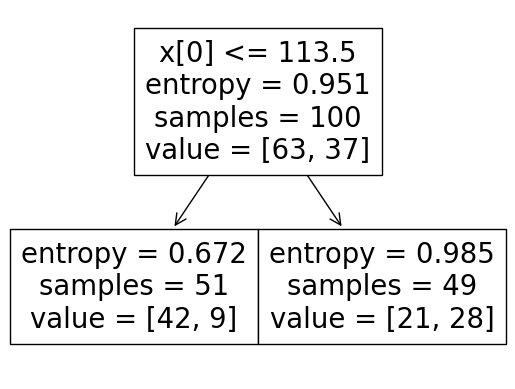

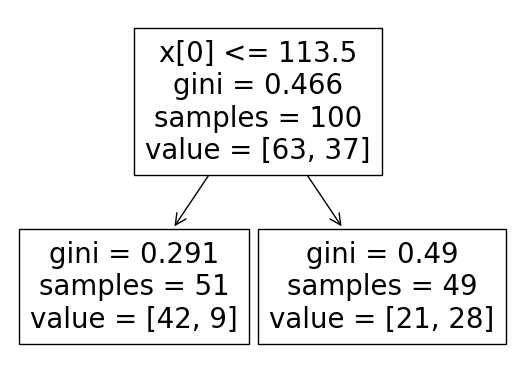

In [67]:
# Entropy 
clf_entropy = DecisionTreeClassifier(criterion = "entropy", max_depth=1)
clf_entropy.fit(feature.reshape(-1,1), labels)
plt.figure()
plot_tree(clf_entropy)

# Gini index
clf_gini = DecisionTreeClassifier(criterion = "gini", max_depth=1)
clf_gini.fit(feature.reshape(-1,1), labels)
plt.figure()
plot_tree(clf_gini)


The results are consistent with the previous results except for the fact that the **cut point** becomes **113.5 instead of 113**. That makes no difference as we are **splitting integers** and there is **no values** in $]113;114[$.


## B. Bagging Trees

Single decision trees are known to suffer from high variance. This means that if two decision trees are grown over two disjoint subsamples from the training data, they may lead to quite different results. A general procedure for reducing variance of any learning method is bootstrap aggregating or bagging. *A bootstrap is a set of observations extracted randomly from the original sample, with replacement and of the same size.* Bagging is a methodology that generates multiple bootstrap samples and the classifier is trained with each one and then the outcomes are aggregated. 

>**Question 2: (2 Points)** Compute the probability that a given observation in a data set of size N is part of a bootstrap sample, and study the limit of this probability as N tends to infinity. 


In other words, Question 2 is telling us that approximately one-third of the sample, called set of out-of-bag (OOB) observations, is not being used each time a tree is constructed. These OOB observations will be helpful to compute interesting measures while fitting the model, as we will see in Task 5.

A special case of bagging is the well-known Random Forest model. In the Random Forest model, B decision trees are grown over B bootstrapped training samples and the prediction is the class with majority vote; but additionally, at each time the split at node in a given decision tree is considered, a sample of $m$ predictor variables is chosen randomly among the $d$ initial ones. This randomization helps to decorrelate the trees that are being generated.

An advantage of bagging is that all the trees are grown independently, and hence they can be fit in parallel.

>**Task 4: (5 Points)** Implement the Random Forest classifier using B = 1000 and $m=\lceil \sqrt{d} \rceil$. You can use DecisionTreeClassifier from scikit-learn package together with the fit and predict functions.

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
# Normalization
X_train = (X_train - np.mean(X_train, axis=0))/np.std(X_train, axis=0)
X_test = (X_test - np.mean(X_test, axis=0))/np.std(X_test, axis=0)
def train_and_predict_RF(B, m, X_train, y_train, X_test):
    """
    Inputs:
        B (int): number of trees
        m (int): number of features to be randomly chosen at each split in the tree
        X_train (Nxp matrix): training data
        y_train (N vector): response values
        X_test (N_test x p matrix): test data to be predicted
    Outputs:
        voting_test (N_test vector): 0-1 prediction for each individual in the test data
    """
    voting_test = np.zeros(len(X_test))
    for b in range(B):
        bootstrap_sample = np.random.choice(len(X_train), len(X_train), replace=True)
        X_train_bootstrap = X_train[bootstrap_sample]
        y_train_bootstrap = y_train[bootstrap_sample]
        clf = DecisionTreeClassifier(criterion = "gini", max_depth=1, max_features=m)
        clf.fit(X_train_bootstrap, y_train_bootstrap)
        voting_test += clf.predict(X_test)
    voting_test = np.round(voting_test/B)
    return voting_test

np.random.seed(1)
voting_test = train_and_predict_RF(1000, int(np.round(np.sqrt(8))), X_train, y_train, X_test)
nf_acc_test = np.sum(y_test==voting_test)/len(y_test)
print('The RF accuracy over the test sample is:', nf_acc_test)

The RF accuracy over the test sample is: 0.645021645021645


>**Task 5: (5 Points)** Implement your functions from the labs to compute logistic regression and compare the test accuracy against Random Forest. Use gradient descent with 1000 iterations and a learning rate of $\alpha=0.05$. Please do not make use of the scikit-learn implementation here. 

In [69]:
alpha = 0.05
max_iter = 1000
X_train_LOG, X_test_LOG, y_train_LOG, y_test_LOG = train_test_split(X, y, test_size=0.3, random_state=1)

# Normalization
X_train_LOG = (X_train_LOG - np.mean(X_train_LOG, axis=0))/np.std(X_train_LOG, axis=0)
X_test_LOG = (X_test_LOG - np.mean(X_test_LOG, axis=0))/np.std(X_test_LOG, axis=0)

def sigmoid(z):
    return 1 / (1 + np.exp(-np.clip(z, -10, 10)))

def cost(theta, X, y):
    # Computes the cost using theta as the parameters for logistic regression.
    return np.sum(-y * np.log(sigmoid(X.dot(theta))) - (1 - y) * np.log(1 - sigmoid(X.dot(theta))))   

def compute_grad(theta, X, y):
    # Computes the gradient of the cost with respect to the parameters.
    return X.T.dot(sigmoid(X.dot(theta)) - y)

def gradient_descent(X, y, max_iter, alpha):
    # Performs gradient descent to learn theta
    theta = np.zeros(X.shape[1])
    cost_history = []
    for i in range(max_iter):
        theta = theta - alpha * compute_grad(theta, X, y)
        cost_history.append(cost(theta, X, y))
    return theta, cost_history

def predict(theta, X):
    return np.round(sigmoid(X.dot(theta)))

theta, cost_history = gradient_descent(X_train_LOG, y_train_LOG, max_iter, alpha)
lr_accuracy = 1 - np.mean(np.abs(predict(theta,X_test_LOG)-y_test_LOG))
print('The LR accuracy over the test sample is:', lr_accuracy)
print('The learnt coefficients are:', theta)

The LR accuracy over the test sample is: 0.6796536796536796
The learnt coefficients are: [-1.43480948  4.79053586 -1.15309474  2.6103201   2.61147289  4.58239956
  2.15783991 -2.33977371]


In the following, we will study a variable importance measure designed for Random Forest: the Mean Decrease Accuracy (MDA), also known as the permutation importance measure. MDA is based on the following principle: if a variable is not influential in the model, rearranging the values it takes should not degrade prediction accuracy. If the predictor variable brings nothing but random noise, the prediction accuracy will likely not to be affected after the permutation. Every time an individual tree is grown over a bootstrap sample, accuracy in OOB observations is going to be computed. Also, accuracy in OOB observations after permuting the values of some predictor variable will be computed. The MDA of that predictor variable is obtained by averaging over all trees the differences of both accuracies, that is, accuracy in OOB observations before permuting minus accuracy in OOB observations after permuting.

>**Task 6: (6 Points)** Complete the function below in order to compute the Mean Decrease Accuracy of each predictor variable at the same time of model fitting.  You can use DecisionTreeClassifier from scikit-learn package together with the fit and predict functions.

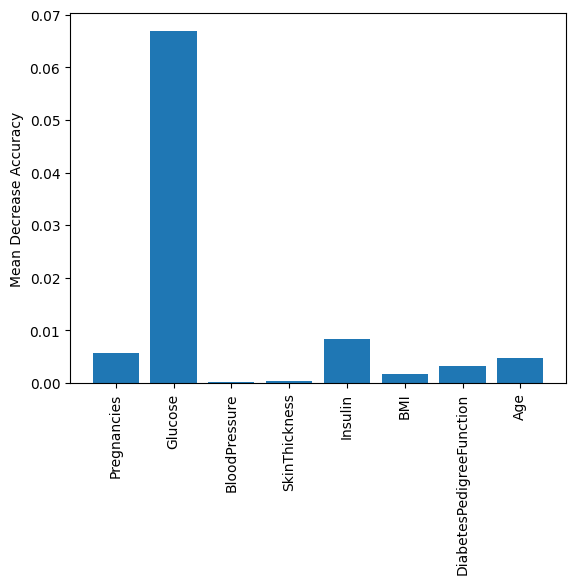

In [70]:
def variable_importance_RF(B, m, X_train, y_train):
    """
    Inputs:
        B (int): number of trees
        m (int): number of features to be randomly chosen at each split in the tree
        X_train (Nxd matrix): training data
        y_train (N vector): response values
    Outputs:
        variable_importance (d vector): MDA of each predictor variable
    """
    variable_importance = np.zeros(X_train.shape[1])
    for b in range(B):
        bootstrap_sample = np.random.choice(len(X_train), len(X_train), replace=True)
        X_train_bootstrap = X_train[bootstrap_sample]
        y_train_bootstrap = y_train[bootstrap_sample]
        clf = DecisionTreeClassifier(criterion = "gini", max_depth=1, max_features=m)
        clf.fit(X_train_bootstrap, y_train_bootstrap)
        # Calculate the MDA for each variable
        for i in range(X_train.shape[1]):
            X_train_permutation = X_train_bootstrap.copy()
            X_train_permutation[:,i] = np.random.permutation(X_train_permutation[:,i])
            variable_importance[i] -= np.sum(clf.predict(X_train_permutation) == y_train_bootstrap)/len(y_train_bootstrap) - np.sum(clf.predict(X_train_bootstrap) == y_train_bootstrap)/len(y_train_bootstrap)
    variable_importance = variable_importance/B
    return variable_importance

np.random.seed(1)
mda = variable_importance_RF(1000, int(np.round(np.sqrt(8))), X_train, y_train)
plt.figure()
plt.bar(np.arange(1,9), mda)
plt.ylabel('Mean Decrease Accuracy')
plt.xticks(np.arange(1,9), features, rotation=90)
plt.show()

>**Question 3: (3 Points)** Which is the most important predictor according to MDA? Is this information consistent with the fitted logistic regression parameters obtained from Task 5? In addition, discuss the sign of the parameter linked to this predictor variable in the logistic regression. 

## C. Boosting Trees

The motivation for boosting is to combine the outputs of many weak classifiers to produce a robust model. A weak classifier is one whose error rate is only slightly better than random guessing. The purpose of boosting is to sequentially apply the weak classification algorithm to repeatedly modified versions of the data, thereby producing a sequence of weak classifiers. The predictions from all of them are then aggregated through a weighted majority vote to produce the final prediction. Contrary to bagging, boosting cannot be parallelized because each new version of the data that is dependent on the previous output. One of the most popoular boosting algorithm is AdaBoost, that we briefly summarize below.

### AdaBoost

In AdaBoost, the data modifications at each boosting step consist of applying weights $w_1, \ldots, w_N$ to each of the training observations. Initially all of the weights are set to $w_i = 1/N$, so that the first step simply trains the classifier on the data in the usual manner. For each successive iteration $b = 2, 3, \ldots, B$ the observation weights are individually modified and the classification algorithm is reapplied to the weighted observations. At step $b$, those observations that were misclassified by the classifier induced at the previous step have their weights increased, whereas the weights are decreased for those that were classified correctly. Thus as iterations proceed, observations that are difficult to classify correctly receive ever-increasing influence. Each successive classifier is thereby forced to concentrate on those training observations that are missed by previous ones in the sequence.

1. Initialize the observations weights $w_i = 1/N, i = 1,\ldots,N$.
2. For $b=1$ to $B$:\
a) Fit a weak classifier $C_b(x)$ to the training data using weights $w_i$.\
b) Compute the weighted error obtained with $C_b$, i.e., $e_b = \frac{\sum_{i=1}^N w_i I (y_i \neq C_b(x_i))}{\sum_{i=1}^N w_i}$.\
c) Compute $\alpha_b = log((1-e_b)/e_b)$.\
d) Set $w_i$ to $w_i exp[\alpha_b I (y_i \neq C_b(x_i))], i = 1,\ldots,N$.
3. The final predictor function is $C(x) = \frac{\sum_{b=1}^B \alpha_b C_b(x)}{\sum_{b=1}^B \alpha_b}$.

>**Task 7: (8 Points)** Implement AdaBoost classifier using as weak classifier a DecisionTreeRegressor from scikit-learn package with one single split. You have to figure out how to pass the weight vector to the <code>fit</code> function. Compute at each boosting step the training and test accuracies so you can plot the learning curves as a function of the number of iterations. 

The AdaBoost accuracy over the test sample is: 0.8138528138528138


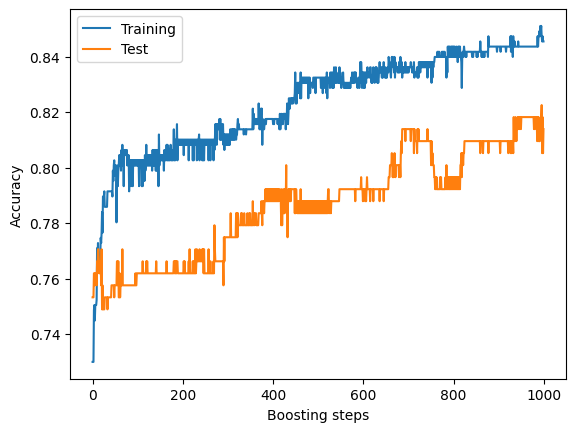

0


In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
B = 1000

def train_and_predict_AdaBoost(B, X_train, y_train, X_test, y_test):
    """
    Inputs:
        B (int): number of boosting steps
        X_train (Nxp matrix): training data
        y_train (N vector): response training values
        X_test (N_test x p matrix): test data to be predicted
        y_test (N vector): response test values
    Outputs:
        acc_train (B vector): train accuracy per boosting step 
        acc_test (B vector): test accuracy per boosting step
        w_all (NxB matrix): weights computed for all the samples per boosting step
    """
    N = X_train.shape[0]
    W = np.ones(N)/N
    classifiers = []
    alphas = []
    acc_train = np.zeros(B)
    acc_test = np.zeros(B)
    w_all = np.zeros((N,B))
    for b in range (B):
        # Building the classifier
        clf = DecisionTreeClassifier(criterion = "gini", max_depth=1)
        clf.fit(X_train, y_train, sample_weight = W)
        classifiers.append(clf)

        # Predict the trainig set
        y_pred_train = clf.predict(X_train)

        # Computing the error 
        eb = 0
        for j in range (N):
            if y_pred_train[j] !=  y_train[j]:
                eb += W[j]
        eb = eb/np.sum(W)

        # Computing the alpha
        alpha = np.log((1-eb)/eb)
        alphas.append(alpha)

        # Updating the weights
        for j in range (N):
            if y_pred_train[j] != y_train[j]:
                W[j] = W[j]*np.exp(alpha)
        W = W/np.sum(W)
        w_all[:,b] = W

        # Final predictor
        y_pred_train_final = np.zeros(N)
        for i in range (b+1):
            y_pred_train_final += alphas[i]*classifiers[i].predict(X_train)
        y_pred_train_final = np.round(y_pred_train_final/np.sum(alphas))
        acc_train[b] = np.sum(y_pred_train_final == y_train)/N

        # Predict the test set
        y_pred_test = np.zeros(len(X_test))
        for i in range (b+1):
            y_pred_test += alphas[i]*classifiers[i].predict(X_test)
        y_pred_test = np.round(y_pred_test/np.sum(alphas))
        acc_test[b] = np.sum(y_pred_test == y_test)/len(y_test)
        
    return acc_train, acc_test, w_all

ada_acc_train, ada_acc_test, w_all = train_and_predict_AdaBoost(B, X_train, y_train, X_test, y_test)

print('The AdaBoost accuracy over the test sample is:', ada_acc_test[B-1])

plt.figure()
plt.plot(ada_acc_train, label="Training")
plt.plot(ada_acc_test, label="Test")
plt.xlabel('Boosting steps')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
print(np.sum([1,2,2]==[1,2,3]))

>**Task 8/Question 4: (5 Points)** Read in the simulated data set. It consists of two predictors and a binary response variable. Perform a train-test splitting and run your function train_and_predict_AdaBoost. Plot the average weights across all the boosting steps per each observation in the training sample by means of a barplot. What can you observe? Regarding to this observation, can you explore a potential problem of AdaBoost?

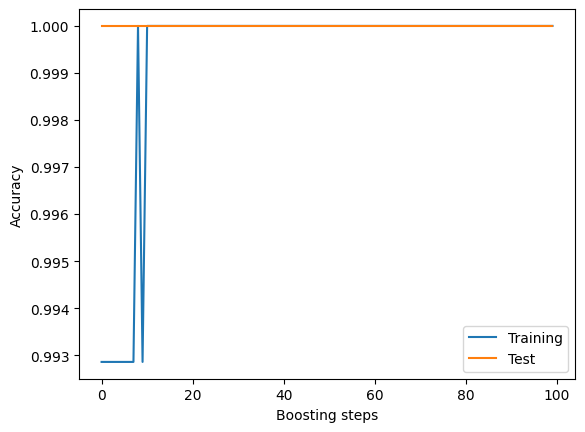

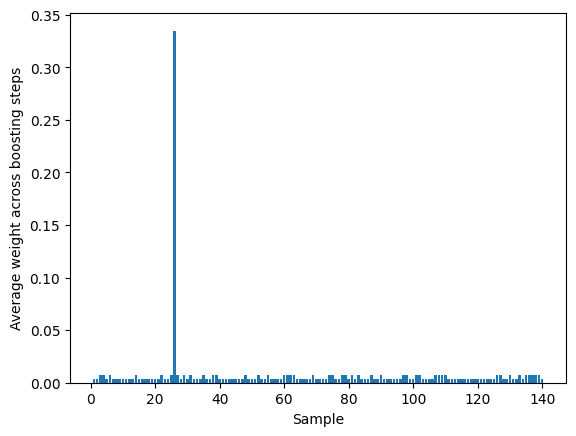

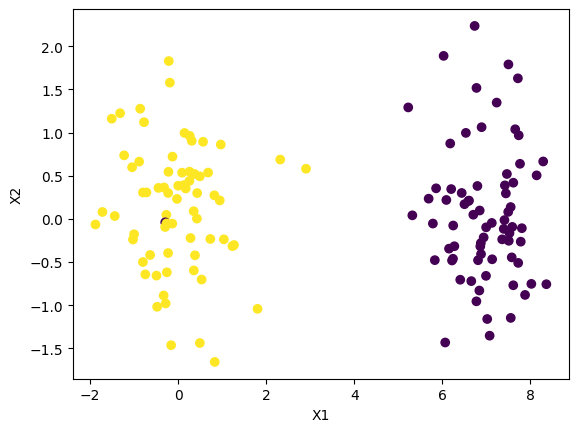

In [72]:
sim = np.loadtxt("simulated.txt", delimiter=',')

n_test = 60
X_sim_train = sim[:-n_test, 0:2]
y_sim_train = sim[:-n_test, -1]
X_sim_test = sim[-n_test:, 0:2]
y_sim_test = sim[-n_test:, -1]

B = 100
acc_train, acc_test, w_all = train_and_predict_AdaBoost(B, X_sim_train, y_sim_train, X_sim_test, y_sim_test)

# Plotting the accuracy per boosting step
plt.figure()
plt.plot(acc_train, label="Training")
plt.plot(acc_test, label="Test")
plt.xlabel('Boosting steps')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting the average weights across al boosting steps for each sample (barplot)
plt.figure()
plt.bar(np.arange(1, len(X_sim_train)+1), np.mean(w_all, axis=1))
plt.xlabel('Sample')
plt.ylabel('Average weight across boosting steps')
plt.show()

plt.figure()
plt.scatter(X_sim_train[:,0], X_sim_train[:,1], c=y_sim_train)
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

>**Question 5/Task 9: (5 Points)** Propose a modification of AdaBoost algorithm that aims to solve this problem, that is, propose a different probability distribution of the weights that you would use, and explain why this could work.

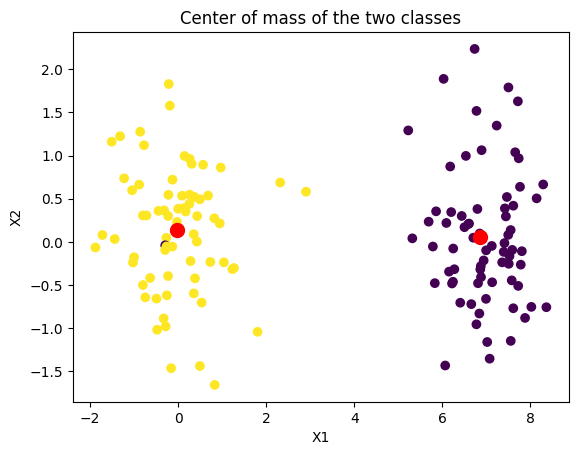

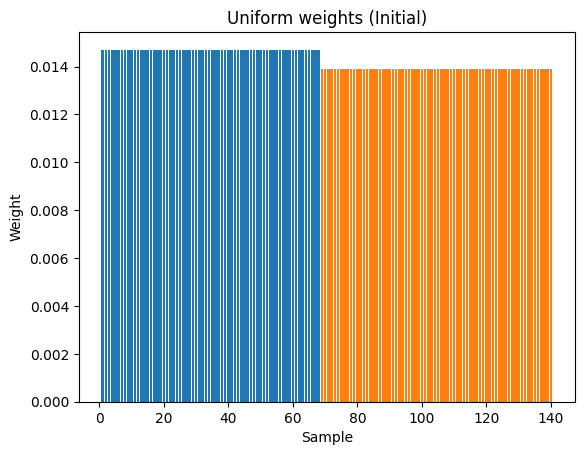

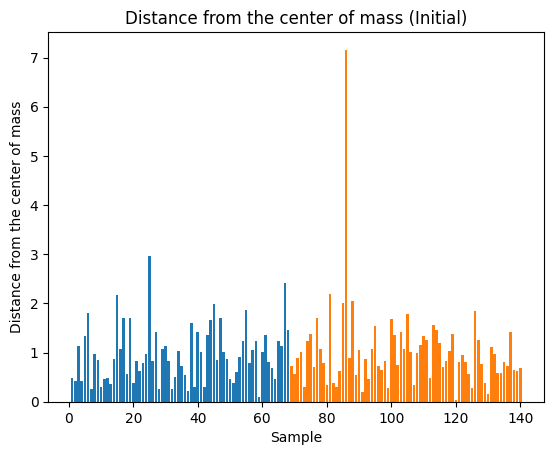

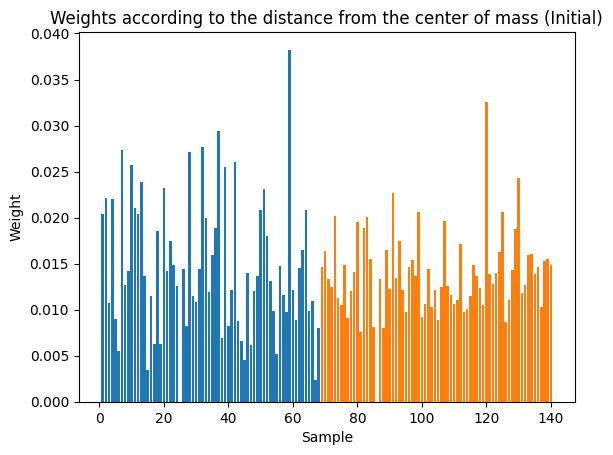

In [81]:

# A different probability distibution og the weights would be :

# Compute the center of mass of the two classes
mu_1 = np.mean(X_sim_train[y_sim_train==1], axis=0)
mu_0 = np.mean(X_sim_train[y_sim_train==0], axis=0)

# Plot the center of mass of the two classes
plt.figure()
plt.title('Center of mass of the two classes')
plt.scatter(X_sim_train[:,0], X_sim_train[:,1], c=y_sim_train)
plt.scatter(mu_1[0], mu_1[1], c='r', s=100)
plt.scatter(mu_0[0], mu_0[1], c='r', s=100)
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

# Compute the distance of each sample from the center of mass of its class
distance_1 = np.linalg.norm(X_sim_train[y_sim_train==1] - mu_1, axis=1)
distance_0 = np.linalg.norm(X_sim_train[y_sim_train==0] - mu_0, axis=1)
max_distance_1 = np.max(distance_1)
max_distance_0 = np.max(distance_0)

# Attribute the weights to each sample according to the distance from the center of mass of its class (log)

w_1 = np.log(max_distance_1/distance_1)
w_0 = np.log(max_distance_0/distance_0)
w_1 = w_1/np.sum(w_1)
w_0 = w_0/np.sum(w_0)

W = [w_0, w_1]

# Plotting the weights before and after
plt.figure()
plt.bar(np.arange(1, len(X_sim_train[y_sim_train==1])+1), 1/len(X_sim_train[y_sim_train==1])*np.ones(len(X_sim_train[y_sim_train==1])))
plt.bar(np.arange(len(X_sim_train[y_sim_train==1])+1, len(X_sim_train)+1), 1/len(X_sim_train[y_sim_train==0])*np.ones(len(X_sim_train[y_sim_train==0])))
plt.xlabel('Sample')
plt.ylabel('Weight')
plt.title('Uniform weights (Initial)')
plt.show()
# Plotting the distance from the center of mass of the two classes
plt.figure()
plt.bar(np.arange(1, len(X_sim_train[y_sim_train==1])+1), distance_1)
plt.bar(np.arange(len(X_sim_train[y_sim_train==1])+1, len(X_sim_train)+1), distance_0)
plt.xlabel('Sample')
plt.ylabel('Distance from the center of mass')
plt.title('Distance from the center of mass (Initial)')
plt.show()
# Plotting the weights after
plt.bar(np.arange(1, len(X_sim_train[y_sim_train==1])+1), w_1)
plt.bar(np.arange(len(X_sim_train[y_sim_train==1])+1, len(X_sim_train)+1), w_0)
plt.xlabel('Sample')
plt.ylabel('Weight')
plt.title('Weights according to the distance from the center of mass (Initial)')
plt.show()

### XGBoost and LightGBM

Gradient Boosting is a generalization of AdaBoost to a statistical framework that treats the training process as an additive model and allows arbitrary differentiable loss functions to be optimized using gradient descent.

<a href="https://arxiv.org/pdf/1603.02754.pdf">Extreme Gradient Boosting</a> (XGBoost) and <a href="https://papers.nips.cc/paper_files/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf">Light Gradient Boosting Machines</a> (LightGBM) are two popular efficient implementations of Gradient Boosting. 

>**Question 6: (4 Points)** Describe the main characteristics of XGBoost and LightGBM in four sentences each. 

>**Task 10: (2 Points)** Implement both XGBoost and LightGBM with 1000 trees at maximum depth $1$, and compare their test accuracy over the Pima-indians-diabetes dataset to logistic regression, Random Forest and AdaBoost. You can use XGBClassifier from xgboost package, and LGBMClassifier from lightgbm package with a learning rate of 0'15.

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

def train_and_predict_xgBoost(X_train, y_train, X_test, y_test):
    clf = XGBClassifier(max_depth=1, n_estimators=1000, learning_rate=0.15)
    clf.fit(X_train, y_train)
    y_pred_test = clf.predict(X_test)
    acc_test = np.sum(y_pred_test == y_test)/len(y_test)
    return acc_test

acc_test_xgbc = train_and_predict_xgBoost(X_train, y_train, X_test, y_test)


print('The XGBoost accuracy over the test sample is:', acc_test_xgbc)

The XGBoost accuracy over the test sample is: 0.8225108225108225


In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

def train_and_predict_LGBM(X_train, y_train, X_test):
    clf = LGBMClassifier(max_depth=1, n_estimators=1000, learning_rate=0.15)
    clf.fit(X_train, y_train)
    y_pred_test = clf.predict(X_test)
    acc_test = np.sum(y_pred_test == y_test)/len(y_test)
    return acc_test

acc_test_lgbmc = train_and_predict_LGBM(X_train, y_train, X_test)

print('The LightGBM accuracy over the test sample is:', acc_test_lgbmc)

[LightGBM] [Info] Number of positive: 183, number of negative: 354
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 609
[LightGBM] [Info] Number of data points in the train set: 537, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.340782 -> initscore=-0.659811
[LightGBM] [Info] Start training from score -0.659811
The LightGBM accuracy over the test sample is: 0.7965367965367965


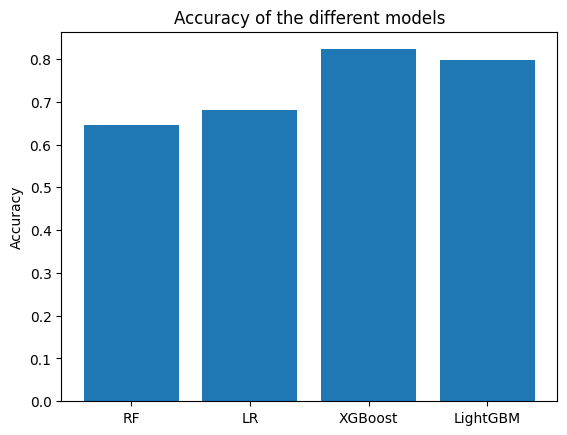

In [82]:
# Comparing the models accuracy

plt.figure()
plt.title('Accuracy of the different models')
plt.bar(np.arange(1,5), [nf_acc_test, lr_accuracy, acc_test_xgbc, acc_test_lgbmc])
plt.xticks(np.arange(1,5), ['RF', 'LR', 'XGBoost', 'LightGBM'])
plt.ylabel('Accuracy')
plt.show()

